### Importing Libraries.

In [ ]:
from scipy.special import factorial
import numpy as np
np.math = type('math', (), {})()
np.math.factorial = factorial

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.active_learning import GreedyAlgorithm
from deepsensor.active_learning.acquisition_fns import Stddev, JointEntropy, MeanMarginalEntropy, Random, MeanStddev, MeanMarginalEntropy, ContextDist, ExpectedImprovement, MeanVariance

from tqdm.notebook import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import dill
import warnings
import pandas as pd
import cartopy.crs as ccrs
import os

set_gpu_default_device()

### Assigning the boundary variables for India.

In [3]:

# File names
wustl_file = "/home/tanutiwari/Documents/WUSTL_with_population_data/WUSTL_pop_combinedfile/AllWUSTL_population2000_2019.nc"

# exact lat-lon boundaries
lat_min, lat_max = 6.0, 37.5
lon_min, lon_max = 66.5, 98.5

# NetCDF datasets 
data_wustl = xr.open_dataset(wustl_file)

# Checking order for latitude (WUSTL dataset)
lat_values_wustl = data_wustl["lat"].values
if lat_values_wustl[0] > lat_values_wustl[-1]:  # Descending order
    data_wustl_india = data_wustl.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:  # Ascending order
    data_wustl_india = data_wustl.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

In [4]:
data_wustl_india

<xarray.Dataset> Size: 290MB
Dimensions:     (time: 240, lat: 315, lon: 320)
Coordinates:
  * lat         (lat) float32 1kB 6.05 6.15 6.25 6.35 ... 37.25 37.35 37.45
  * lon         (lon) float32 1kB 66.55 66.65 66.75 66.85 ... 98.25 98.35 98.45
  * time        (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2019-12-31
Data variables:
    PM25        (time, lat, lon) float32 97MB ...
    population  (time, lat, lon) float64 194MB ...
Attributes:
    TITLE:            Convolutional Neural Network Monthly PM2.5 Estimation o...
    CONTACT:          SIYUAN SHEN <s.siyuan@wustl.edu>
    LAT_DELTA:        0.1
    LON_DELTA:        0.1
    SPATIALCOVERAGE:  AS
    TIMECOVERAGE:     200001

### Dataprocessor

In [5]:
# ignore warnings
warnings.filterwarnings("ignore")
data_processor = DataProcessor(x1_name="lat", x2_name="lon")
wustl_ds = data_processor(data_wustl_india)

In [6]:
wustl_ds

<xarray.Dataset> Size: 290MB
Dimensions:     (time: 240, x1: 315, x2: 320)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2019-12-31
  * x1          (x1) float32 1kB 0.0 0.003135 0.00627 ... 0.9781 0.9812 0.9843
  * x2          (x2) float32 1kB 0.0 0.003135 0.006269 ... 0.9937 0.9969 1.0
Data variables:
    PM25        (time, x1, x2) float32 97MB -0.6727 -0.6821 ... -0.7271 -0.7255
    population  (time, x1, x2) float64 194MB -1.005 -1.005 ... -0.05214 -0.05214
Attributes:
    TITLE:            Convolutional Neural Network Monthly PM2.5 Estimation o...
    CONTACT:          SIYUAN SHEN <s.siyuan@wustl.edu>
    LAT_DELTA:        0.1
    LON_DELTA:        0.1
    SPATIALCOVERAGE:  AS
    TIMECOVERAGE:     200001

### Initialising taskloader and ConvNP model.

In [191]:
task_loader = TaskLoader(
    context=[wustl_ds.PM25,wustl_ds.population],
    target=wustl_ds.PM25,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('PM25',), ('population',))
Target variable IDs: (('PM25',),)


### Defining task and training the model.

In [196]:
# generating date range for tasks
def gen_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates, disable=not progress):
        N_c = np.random.randint(0, 1000)
        task = task_loader(date, context_sampling=[N_c,"all"], target_sampling="all")
        tasks.append(task)
    return tasks

In [ ]:
# specifying the date ranges.

train_dates = pd.date_range(start='2000-01-31T00:00:00.000000000', end='2010-12-31T00:00:00.000000000', freq='ME')
Al_dates =    pd.date_range(start='2011-01-31T00:00:00.000000000', end='2015-12-31T00:00:00.000000000', freq='ME')
test_dates =  pd.date_range(start='2016-01-31T00:00:00.000000000', end='2019-12-31T00:00:00.000000000', freq='ME')


In [198]:
train_dates, Al_dates, test_dates

(DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
                '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
                '2000-09-30', '2000-10-31',
                ...
                '2010-03-31', '2010-04-30', '2010-05-31', '2010-06-30',
                '2010-07-31', '2010-08-31', '2010-09-30', '2010-10-31',
                '2010-11-30', '2010-12-31'],
               dtype='datetime64[ns]', length=132, freq='ME'),
 DatetimeIndex(['2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30',
                '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
                '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-31',
                '2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
                '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
                '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31',
                '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
                '2013-05-31', '2013-

### Genrating tasks.

In [199]:
train_tasks = gen_tasks(train_dates)
Al_tasks    = gen_tasks(Al_dates)
test_tasks  = gen_tasks(test_dates)

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

### Initializing the model 

In [ ]:
def compute_rmse(model, tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]
    for task in tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [220]:
model = ConvNP(data_processor, task_loader, unet_channels=(32, 32, 32, 32, 32))

dim_yc inferred from TaskLoader: (1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 319
encoder_scales inferred from TaskLoader: [np.float32(0.0015673981), np.float32(0.0015673981)]
decoder_scale inferred from TaskLoader: 0.003134796238244514


In [221]:
compute_rmse(model, test_tasks)

np.float32(29.404142)

In [222]:
losses = []
test_rmses = []
test_rmse_best = np.inf

### Initializing model

### Training model on train dates

In [223]:
trainer = Trainer(model, lr=5e-5)

for epoch in tqdm(range(155)): 
    train_tasks = gen_tasks(train_dates, progress=False)
    batch_losses = trainer(train_tasks)
    losses.append(np.mean(batch_losses))
    test_rmses.append(compute_rmse(model, test_tasks))
    if test_rmses[-1] < test_rmse_best:
        test_rmse_best = test_rmses[-1]

  0%|          | 0/155 [00:00<?, ?it/s]

### Plotting train rmse.

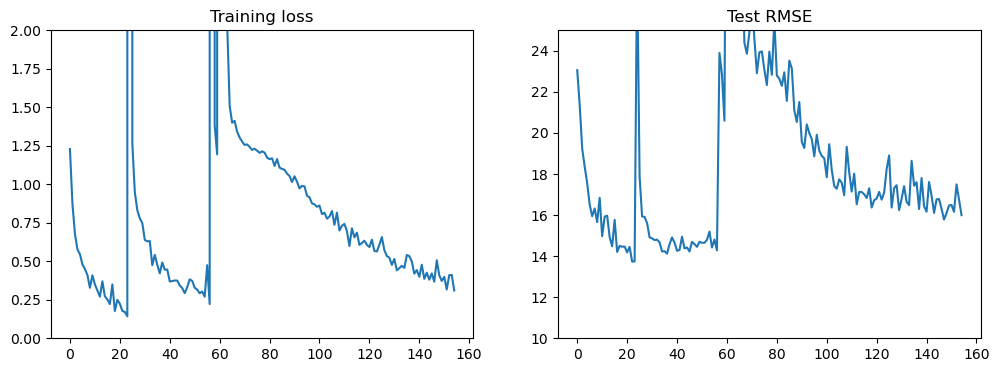

In [224]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.ylim(0,2)
plt.title("Training loss")
plt.subplot(1, 2, 2)
plt.plot(test_rmses)
plt.ylim(10, 25)
plt.title("Test RMSE")
plt.show()

In [225]:
compute_rmse(model, test_tasks)

np.float32(15.995653)

### Taking potential pool points with Active Learning Years.

In [ ]:
from deepsensor.active_learning import GreedyAlgorithm
from deepsensor.active_learning.acquisition_fns import Stddev

acquisition_fn = Stddev(model, context_set_idx=0, target_set_idx=0)

alg = GreedyAlgorithm(
    model,
    X_s=data_wustl_india,
    X_t=data_wustl_india.PM25,
    context_set_idx=0,
    target_set_idx=0,
    N_new_context=3,
    progress_bar=True,
)

In [234]:
task = task_loader(Al_dates, context_sampling=50)
task

[time: Timestamp/2011-01-31 00:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 50)', 'ndarray/float32/(2, 50)']
 Y_c: ['ndarray/float32/(1, 50)', 'ndarray/float32/(1, 50)']
 X_t: None
 Y_t: None,
 time: Timestamp/2011-02-28 00:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 50)', 'ndarray/float32/(2, 50)']
 Y_c: ['ndarray/float32/(1, 50)', 'ndarray/float32/(1, 50)']
 X_t: None
 Y_t: None,
 time: Timestamp/2011-03-31 00:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 50)', 'ndarray/float32/(2, 50)']
 Y_c: ['ndarray/float32/(1, 50)', 'ndarray/float32/(1, 50)']
 X_t: None
 Y_t: None,
 time: Timestamp/2011-04-30 00:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 50)', 'ndarray/float32/(2, 50)']
 Y_c: ['ndarray/float32/(1, 50)', 'ndarray/float32/(1, 50)']
 X_t: None
 Y_t: None,
 time: Timestamp/2011-05-31 00:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 50)', 'ndarray/float32/(2, 50)']
 Y_c: ['ndarray/float32/(1, 50)', 'ndarray/float32/(1, 50)']
 X_t: None
 Y_t: None,
 time: Timestamp/2011-06-30 00:00:00
 ops: []

In [235]:
X_new_df, acquisition_fn_ds = alg(acquisition_fn, task)

100%|██████████| 180/180 [00:07<00:00, 25.29it/s]


Averaging acquisition function over dims for plotting: ['time']


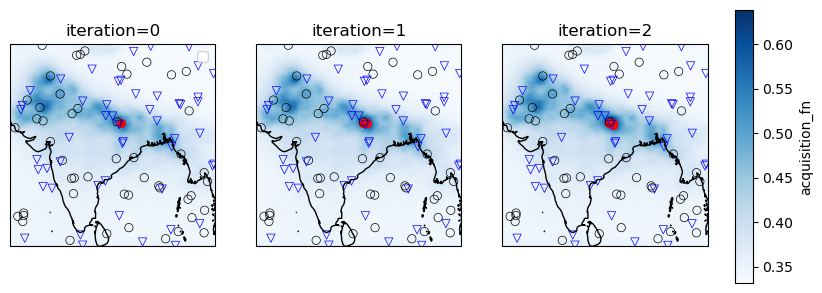

In [236]:
fig = deepsensor.plot.acquisition_fn(
    task[0], acquisition_fn_ds, X_new_df,
    data_processor, crs=ccrs.PlateCarree(), add_colorbar=True,
    cmap="Blues")

In [237]:
X_new_df

,lat,lon
iteration,,
0,25.250000,83.750000
1,25.250000,83.150002
2,24.849998,83.750000
